In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.listdir(("/content/drive/My Drive/")))

['splnproc1703_mac.docm', 'Classroom', 'CSE3223_170104142_PartA_SectionC.pdf', 'CSE3213_170104142_PartA_SectionC.pdf', 'CSE3215_170104142_PartA_SectionC.pdf', '170104142 (5).pdf', 'CSE3213_170104142_PartA.pdf', 'CSE3213_170104142_partB.pdf', 'CSE3211_170104142_PartA .pdf', 'CSE3211_170104142_partB.pdf', 'HUM3207_170104142_partA.pdf', 'HUM3207_170104142_partB.pdf', 'CSE3223_170104142_partA.pdf', 'CSE3223_170104142_partB.pdf', 'CSE3215_170104142_partA.pdf', 'CSE3215_170104142_partB (1).pdf', 'CSE3215_170104142_partB.pdf', 'thesis', 'compiler lab return', '170104142_Assignment1 (1).pdf', '170104142_Assignment1.c', 'input1.c', 'DDS', 'C2_170104142 (1).pdf', '170104142 (4).pdf', 'C2_170104142.pdf', '170104142_on1 (1).c', '170104142_on1.c', 'MSD_proposal3.2.pptx', ' Introduction to IPv4 and Ipv6 Address.gslides', '170104142_quiz1.pdf', 'QUIZ - 01 SET - C_170104142.gdoc', '41', 'C2_170104142_assignment2.docx', '170104142_Assignment-2.pdf', '170104142_Assignment2.pdf', '170104142_Assignment2.c

In [ ]:
path = "/content/drive/My Drive/"

dataset_A = path + 'Dataset A.zip'
with ZipFile(dataset_A, 'r') as zip:
  zip.extractall()

In [ ]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-a.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(19702, 2)


,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0


In [ ]:
TRAIN_PATH = "/content/drive/My Drive/Train"
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = "/content/" + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-a')

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)



In [ ]:
batch_size = 350
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 300 # num of hidden nodes
output_dim = 10

learning_rate = 0.02  # More power so we can learn faster! previously it was 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

355


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:46
Test dataloader:12


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.Softmax(dim=0)
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas


In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=300, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=300, out_features=300, bias=True)
  (relu_2): ReLU()
  (linear_3): Linear(in_features=300, out_features=300, bias=True)
  (relu_3): Softmax(dim=0)
  (linear_4): Linear(in_features=300, out_features=300, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=300, out_features=300, bias=True)
  (relu_5): ReLU()
  (linear_6): Linear(in_features=300, out_features=300, bias=True)
  (relu_6): ReLU()
  (linear_out): Linear(in_features=300, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Iteration: 500. Loss: 1.595639944076538. Accuracy: 31.497461928934012
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Iteration: 1000. Loss: 1.5508804321289062. Accuracy: 33.09644670050761
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Iteration: 1500. Loss: 0.9442182183265686. Accuracy: 62.63959390862944
Epoch:  34
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Iteration: 2000. Loss: 0.800396203994751. Accuracy: 66.24365482233503
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Iteration: 2500. Loss: 0.7425801157951355. Accuracy: 66.16751269035532
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch: 

In [ ]:
#settings 1
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), path + 'assignment2_model.pkl') 

[1.595639944076538, 1.5508804321289062, 0.9442182183265686, 0.800396203994751, 0.7425801157951355, 0.5644039511680603, 0.4363650977611542, 0.5090310573577881, 0.40122079849243164, 0.3894078731536865, 0.29310184717178345, 0.27039575576782227, 0.28251132369041443, 0.2703360319137573, 0.19153642654418945, 0.1642908751964569, 0.17831802368164062, 0.09835110604763031, 0.10190308839082718, 0.08469339460134506, 0.11785721778869629, 0.15357400476932526, 0.8374305367469788, 0.08934945613145828, 0.059991564601659775, 0.08881527185440063, 0.06875539571046829, 0.08037525415420532, 0.03640779107809067, 0.02747102454304695, 0.07288433611392975, 0.021865112707018852]


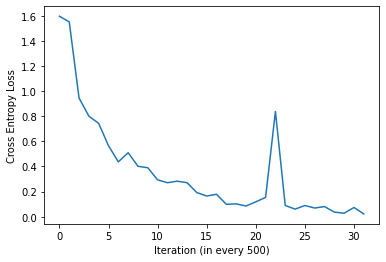

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

In [ ]:
print("Final Model Loss: ",iteration_loss[-1])
print ("Final Model Accuracy: ",accuracy)

Final Model Loss:  0.021865112707018852
Final Model Accuracy:  89.06091370558376


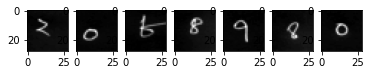

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 7)
for i in range(7):
    ax[i].imshow(images[i].view(28,28), cmap=matplotlib.cm.binary)

plt.show()